In [1]:
import os, json
import openai
import torch
import torch.nn
from transformers import BertModel, BertTokenizer
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, roc_curve, f1_score
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

/home/ushnish/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
categories = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

def prep_df(filename):
    df = pd.read_csv(filename, engine='python', encoding='unicode_escape', on_bad_lines = 'warn')
    for c in categories:
        # convert "0" and "1" to 0. and 1.
        df[c] = pd.to_numeric(df[c], downcast='float', errors='coerce')
        # throw away any rows where the label is not 0. or 1. (may happen to due to parsing errors)
        df = df[(df[c] >= 0) & (df[c] <= 1)]
    return df

In [3]:
df_val = prep_df("data/val_split.csv")


Skipping line 4: ',' expected after '"'
Skipping line 37: ',' expected after '"'
Skipping line 39: ',' expected after '"'
Skipping line 105: ',' expected after '"'
Skipping line 111: ',' expected after '"'
Skipping line 116: ',' expected after '"'
Skipping line 375: ',' expected after '"'
Skipping line 495: ',' expected after '"'
Skipping line 500: ',' expected after '"'
Skipping line 709: ',' expected after '"'
Skipping line 774: ',' expected after '"'
Skipping line 791: ',' expected after '"'
Skipping line 804: ',' expected after '"'
Skipping line 820: ',' expected after '"'
Skipping line 824: ',' expected after '"'
Skipping line 1116: ',' expected after '"'
Skipping line 1155: ',' expected after '"'
Skipping line 1206: ',' expected after '"'
Skipping line 1437: ',' expected after '"'
Skipping line 1461: ',' expected after '"'
Skipping line 1493: ',' expected after '"'
Skipping line 1597: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, 

In [14]:
responses = {}
count = 0

for _, row in df_val.iterrows():
    comment = row['comment_text']
    response = openai.ChatCompletion.create(
          model="gpt-3.5-turbo",
          messages=[
            {
              "role": "system",
              "content": """You will be provided with a text comment, and your task is to determine if a label applies to the comment."""
                """The labels are "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"."""
                """The output must only contain the above labels, the word \"not\" and no other words"""
                """Here is an example of the output must look like"""
                """Comment: I think bald men need to be kept away"""
                """Labels: toxic, not severe_toxic, not obscene, not threat, insult, not identity_hate"""
                """Here is another example of the output must look like"""
                """Comment: I'm gonna find you in your house at night"""
                """Labels: toxic, not severe_toxic, not obscene, threat, insult, not identity_hate"""                
            },
            {
              "role": "user",
              "content": "Comment: {}".format(comment)
            }
          ],
          temperature=0,
          max_tokens=64,
          top_p=1.0,
          frequency_penalty=0.0,
          presence_penalty=0.0
        )
    responses[row['id']] = response.choices[0].message.content
    # Keep writing out the output to avoid data loss
    with open('responses_incremental.json', 'w') as f:
        f.write(json.dumps(responses))
    count += 1
    print(count)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


APIError: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 19 Jul 2023 04:58:20 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7e905bf0ff2cbef2-YYC', 'alt-svc': 'h3=":443"; ma=86400'}

In [14]:
import json

with open('responses_incremental.json', 'r') as f:
    responses = json.loads(f.read())
print(len(responses))

894


In [109]:
responses

{'fdfe4657cd211434': 'Labels: not toxic, not severe_toxic, not obscene, not threat, not insult, not identity_hate',
 '838d488c91ee24ff': 'Labels: toxic, not severe_toxic, obscene, threat, not insult, not identity_hate',
 'fa45ff15ec85272b': 'Labels: not toxic, not severe_toxic, not obscene, not threat, not insult, not identity_hate',
 '1b96fb37e3b42fec': 'Labels: toxic, not severe_toxic, obscene, threat, not insult, not identity_hate',
 '2b2e060218052af9': 'Labels: toxic, not severe_toxic, not obscene, not threat, insult, not identity_hate',
 'f840615058d2c892': 'Labels: not toxic, not severe_toxic, not obscene, not threat, not insult, not identity_hate',
 'ef4158d33d2d50f3': 'Labels: not toxic, not severe_toxic, not obscene, not threat, not insult, not identity_hate',
 'f4b213a729650828': 'Labels: not toxic, not severe_toxic, not obscene, not threat, not insult, not identity_hate',
 'edccbc71dbdb7069': 'Labels: not toxic, not severe_toxic, not obscene, not threat, not insult, not iden

In [110]:
responses_clean = {}
label_delim = "Labels: "

# Convert "not toxic" to 0 and "toxic" to 1, repeat for all 6 categories, -99 means we failed
def make_label(text, category):
    text = text.strip()
    if text == "not " + category:
        return 0
    if text == category:
        return 1
    return -99
# ChatGPT output parsing\
for k, labeltext in responses.items():
    ind = labeltext.find(label_delim)
    if ind == -1:
        ind = 0
    else:
        ind += len(label_delim)
    labeltext = labeltext[ind:]
    tokens = labeltext.split(",")
    preds = {}
    categories = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    for i in range(len(categories)):
        category = categories[i]
        preds["pred_" + category] = make_label(tokens[i], category)
    responses_clean[k] = preds


In [111]:
len(responses_clean)

894

In [17]:
import pandas as pd

pred_df = pd.DataFrame.from_dict(responses_clean, orient='index')
pred_df = pred_df.reset_index()
pred_df.rename(columns={"index":"id"})
pred_df.sample(4)

,index,pred_toxic,pred_severe_toxic,pred_obscene,pred_threat,pred_insult,pred_identity_hate
527,1729afe3a0252c77,1,0,1,0,0,0
581,a3db4ffc3a01bae2,0,0,0,0,0,0
578,3bfb235fc0b29587,1,0,0,1,0,0
610,1bc3b7dcdc2f0a7e,1,0,0,0,1,1


In [114]:
merged = pd.merge(df_val, pred_df, left_on='id', right_on='index', how='inner')
merged = merged.drop(["index","Unnamed: 0"], axis=1)
merged.reset_index()
merged.shape[0]

879

In [137]:
for category in categories:
    print(f1_score(merged[category], merged["pred_"+category]))

0.592057761732852
0.34782608695652173
0.6605504587155964
0.09756097560975609
0.5846153846153848
0.14285714285714288


In [4]:
df_train = prep_df("data/train_split.csv")

Skipping line 155: ',' expected after '"'
Skipping line 161: ',' expected after '"'
Skipping line 282: ',' expected after '"'
Skipping line 309: ',' expected after '"'
Skipping line 313: ',' expected after '"'
Skipping line 439: ',' expected after '"'
Skipping line 625: ',' expected after '"'
Skipping line 627: ',' expected after '"'
Skipping line 695: ',' expected after '"'
Skipping line 756: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead
Skipping line 763: ',' expected after '"'
Skipping line 788: ',' expected after '"'
Skipping line 882: ',' expected after '"'
Skipping line 1227: ',' expected after '"'
Skipping line 1384: ',' expected after '"'
Skipping line 1421: ',' expected after '"'
Skipping line 1524: ',' expected after '"'
Skipping line 1607: ',' expected after '"'
Skipping line 1641: ',' expected after '"'
Skipping line 1658: ',' expected after '"'
Skipping line 1700: ',' expected after '"'


In [5]:
df_train.shape

(125905, 9)

In [6]:
train_tokens =  [str(i) for i in df_train['comment_text'].values]
val_tokens =  [str(i) for i in df_val['comment_text'].values]


In [8]:
checkpoint = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(checkpoint)

train_encodings = tokenizer(train_tokens, truncation=True, padding=True)
val_encodings = tokenizer(val_tokens, truncation=True, padding=True)


In [83]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)   

class CustomDatasetNoLabel(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, index):
        item = {key: torch.tensor(val[index]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

In [10]:
train_dataset = CustomDataset(train_encodings, df_train[categories].values)
val_dataset = CustomDataset(val_encodings, df_val[categories].values)


In [31]:
from transformers import BertModel
class CustomBert(torch.nn.Module) :
    def __init__(self, checkpoint, dropout) : 
        super(CustomBert,self).__init__() 
        self.bert = BertModel.from_pretrained(checkpoint) 
        self.dropout = torch.nn.Dropout(dropout) 
        self.linear = torch.nn.Linear(768,6) 
    def forward(self, ids, attention_mask) : 
        out1, out2 = self.bert( 
            ids , 
            attention_mask = attention_mask, 
            return_dict=False
        )
        output = self.dropout(out2) 
        output = self.linear(output) 
        return output 

In [32]:
criterion = torch.nn.BCEWithLogitsLoss()
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

device = 'cuda'
dropout = 0.2
model = CustomBert(checkpoint, dropout)
model.to(device)

# optimizer = AdamW(model.parameters(), lr=1e-5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    i = 0

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for batch in train_loader:

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
        i += 1

    return last_loss

In [33]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/comment_classifier_trainer_{}'.format(timestamp))

EPOCHS = 10

best_vloss = 1_000_000

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    
    i = 0

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for vbatch in val_loader:
            i += 1
            vinput_ids = vbatch['input_ids'].to(device)
            vattention_mask = vbatch['attention_mask'].to(device)
            vlabels = vbatch['labels'].to(device)
            voutputs = model(vinput_ids, attention_mask=vattention_mask)
            vloss = criterion(voutputs, vlabels)
            
            running_vloss += vloss

    avg_vloss = running_vloss / i
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model/bert-batch{}-dropout02-1e5_{}_epoch{}.pt'.format(batch_size, timestamp, epoch)
        torch.save(model.state_dict(), model_path)

    epoch += 1

EPOCH 1:
  batch 100 loss: 0.36640258684754373
  batch 200 loss: 0.14290644001215697
  batch 300 loss: 0.08935072034597397
  batch 400 loss: 0.0805061398074031
  batch 500 loss: 0.07639817874878645
  batch 600 loss: 0.061828424828127025
  batch 700 loss: 0.05856598713435233
  batch 800 loss: 0.05978365395218134
  batch 900 loss: 0.05615735468454659
  batch 1000 loss: 0.05476410089991987
  batch 1100 loss: 0.061141452146694066
  batch 1200 loss: 0.0542139857262373
  batch 1300 loss: 0.05644120631739497
  batch 1400 loss: 0.054174266504123804
  batch 1500 loss: 0.05279324139934033
  batch 1600 loss: 0.048609851053915916
  batch 1700 loss: 0.04272729009855539
  batch 1800 loss: 0.05192207368090749
  batch 1900 loss: 0.05557154537178576
  batch 2000 loss: 0.045801822221837936
  batch 2100 loss: 0.05098776594735682
  batch 2200 loss: 0.055392537424340846
  batch 2300 loss: 0.043593849283643064
  batch 2400 loss: 0.05242296673823148
  batch 2500 loss: 0.05199011897202581
  batch 2600 loss: 0

In [131]:
checkpoint = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(checkpoint)
merge_tokens =  [str(i) for i in merged['comment_text'].values]

merge_encodings = tokenizer(merge_tokens, truncation=True, padding=True)
merge_dataset = CustomDataset(merge_encodings, merged[categories].values)

In [132]:
from torch.utils.data import DataLoader

merge_loader = DataLoader(merge_dataset, batch_size=8)
device = 'cuda'
load_model = CustomBert(checkpoint, 0.1)
load_model.load_state_dict(torch.load("model/bert-batch16-dropout02-1e5_20230812_083817_epoch1.pt"))
load_model.to(device)
load_model.eval()

CustomBert(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [133]:
logit_outputs = []

sigmoid = torch.nn.Sigmoid()
for batch in merge_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)    
    outputs = sigmoid(load_model(input_ids, attention_mask=attention_mask))    
    logit_outputs.append(outputs.cpu().detach().numpy())

100


110

In [134]:
bert_preds = np.vstack(logit_outputs)

for i in range(len(categories)):
    category = categories[i]
    merged["bert_"+category] = bert_preds[:,i]

In [135]:
categories = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

chatgpt_f1scores = {}
bert_f1scores = {}
for i in range(len(categories)):
    category = categories[i]
    chatgpt_f1scores[category] = f1_score(merged[category], merged["pred_" + category])
    
    pred = merged["bert_"+category].values
    fpr, tpr, thresholds = roc_curve(merged[category], pred)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    pred = np.where(pred < optimal_threshold, 0, 1)
    bert_f1scores[category] = f1_score(merged[category], pred)


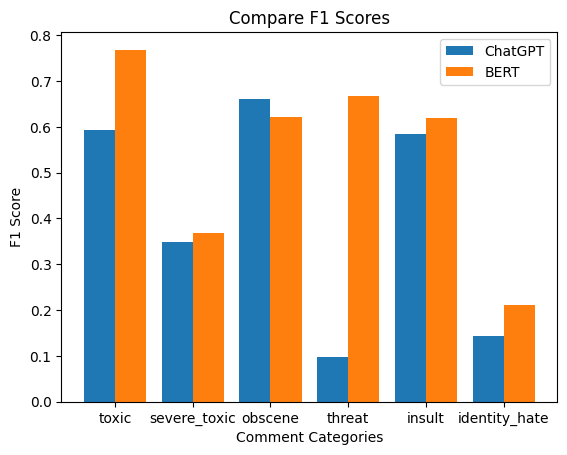

In [136]:
import matplotlib.pyplot as plt 
  
chatgpt_scores = [chatgpt_f1scores[category] for category in categories]
bert_scores = [bert_f1scores[category] for category in categories]
  
X_axis = np.arange(len(categories))
  
plt.bar(X_axis - 0.2, chatgpt_scores, 0.4, label = 'ChatGPT')
plt.bar(X_axis + 0.2, bert_scores, 0.4, label = 'BERT')
  
plt.xticks(X_axis, categories)
plt.xlabel("Comment Categories")
plt.ylabel("F1 Score")
plt.title("Compare F1 Scores")
plt.legend()
plt.show()